# Canguros

## 1. Instalación y configuración

Instalando Keras y tf en las verciones solicitadas

In [ ]:
!pip install keras==2.2.4;
!pip install tensorflow-gpu==1.15.3;
#%tensorflow_version 1.15.3;

!!Reinciar el runtime antes de continuar...

In [2]:
#version de tf y keras
import tensorflow as tf
from tensorflow.keras import __version__;

print('Version de tensor Flow',tf.__version__);
print('Version de Keras:', __version__);

Version de tensor Flow 1.15.3
Version de Keras: 2.2.4-tf


### Clonación del repositorio Mask R-CNN

In [4]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.85 MiB | 20.45 MiB/s, done.
Resolving deltas: 100% (563/563), done.


### Instalación de librería Mask R-CNN

In [5]:
%cd Mask_RCNN

/content/Mask_RCNN


In [6]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mr

## 2. Desarrollo del Dataset **Kangaroo**

### Importación de librerias: plot one photograph and mask

In [7]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray

from mrcnn.utils import Dataset
from matplotlib import pyplot
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

Using TensorFlow backend.


### Montando el drive

In [8]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [14]:
#explorando:
!ls "/content/drive/My Drive/ciclo_02/deep_learning/proyecto_RedesConvolucionales/od_wilber"

rutaRaiz = "/content/drive/My Drive/ciclo_02/deep_learning/proyecto_RedesConvolucionales/od_wilber"

kangaroo  mask_rcnn_coco.h5  trabajoRCNNFinal.ipynb  trabajoRCNN.ipynb


In [15]:
#saliendo a la carpeta raiz:
%cd /content/
!ls

/content
drive  Mask_RCNN  sample_data


### Instalando dataset Kangaroo

In [16]:
#Instalando el Dataset de canguros:
!git clone https://github.com/experiencor/kangaroo.git

Cloning into 'kangaroo'...
remote: Enumerating objects: 334, done.
remote: Total 334 (delta 0), reused 0 (delta 0), pack-reused 334
Receiving objects: 100% (334/334), 18.39 MiB | 6.51 MiB/s, done.
Resolving deltas: 100% (158/158), done.


### Creación de la clase Kangaroo

Aquí se muestra cómo se accede a las imágenes y a las etiquetas de cada una

In [17]:
# Clase que define y carga el dataset Kangaroo
class KangarooDataset(Dataset):
	
	# Cargar las definiciones del dataset
	def load_dataset(self, dataset_dir, is_train=True):

		# Definiendo la clase 'kangaroo' con id = 1
		self.add_class("dataset", 1, "kangaroo")
  
		# Definir localizaciones
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'

		# Encontrar todas las imagenes
		for filename in listdir(images_dir):
    
			# Extrayendo los IDs de las imagenes
			image_id = filename[:-4]
			
    	# Omitiendo las imagenes malas: supongamos que 00090 es defectuoso
			if image_id in ['00090']:
				continue

			# Omitir todas las imágenes después de 150 si estamos construyendo el tren
			if is_train and int(image_id) >= 150:
				continue
			
      # Omitir todas las imágenes antes de 150 si estamos construyendo el conjunto de prueba/val
			if not is_train and int(image_id) < 150:
				continue
      
      # Generando las rutas de cada imagen:
			img_path = images_dir + filename

      # Ubicacion del path de cada etiqueta
			ann_path = annotations_dir + image_id + '.xml'
			
      # Agregando al dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# Extrayendo los archivos Bounding-box
	def extract_boxes(self, filename):
   
		# Carga y analisis del archivo
		tree = ElementTree.parse(filename)
		
		# Obtener la ruta raíz del archivo de label
		root = tree.getroot()
		
		# Extracción de cada Bounding-box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
   
		# Extracción de las dimensiones de las imagenes
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		
		# Retornando el Bounding-box (ancho y alto de la imagen)
		return boxes,width,height;

	# Cargar las máscaras de la imagen
	def load_mask(self, image_id):
   	
		# Obetener detalles de la imagen
		info = self.image_info[image_id]
		
		# Definición de la ubicación del archivo Bounding-box
		path = info['annotation']
		
    # Cargar la etiqueta (XML)
		boxes, w, h = self.extract_boxes(path)
		
    # Crear un array de todas las máscaras, cada una con un canal diferente
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		
    # Creación de las máscaras
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('kangaroo'))
		
		return masks, asarray(class_ids, dtype='int32')

	# Cargar la imagene de referencia
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']


### Preparación de la data de entrenamiento y validación

In [18]:
# Preparando data de entrenamiento
train_set = KangarooDataset()
train_set.load_dataset('kangaroo', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
 
# Preparando data de validación
test_set = KangarooDataset()
test_set.load_dataset('kangaroo', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))


Train: 131
Test: 32


### Realizando pruebas de carga de las imágenes

(431, 580, 3)
(431, 580, 1)


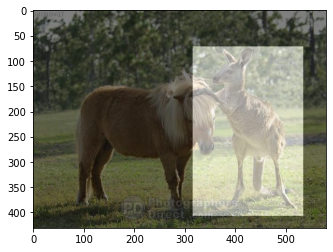

In [19]:
# Probando la clase KangarooDataset
# Cargando una imagen
image_id = 0
image = train_set.load_image(image_id)
print(image.shape)

# Cargando la máscara de una imagen
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)

# Plot de la imagen
pyplot.imshow(image)

# Plot de la máscara
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
pyplot.show()


La libraría mask-rcnn proporciona utilidades para mostrar imágenes y máscaras.


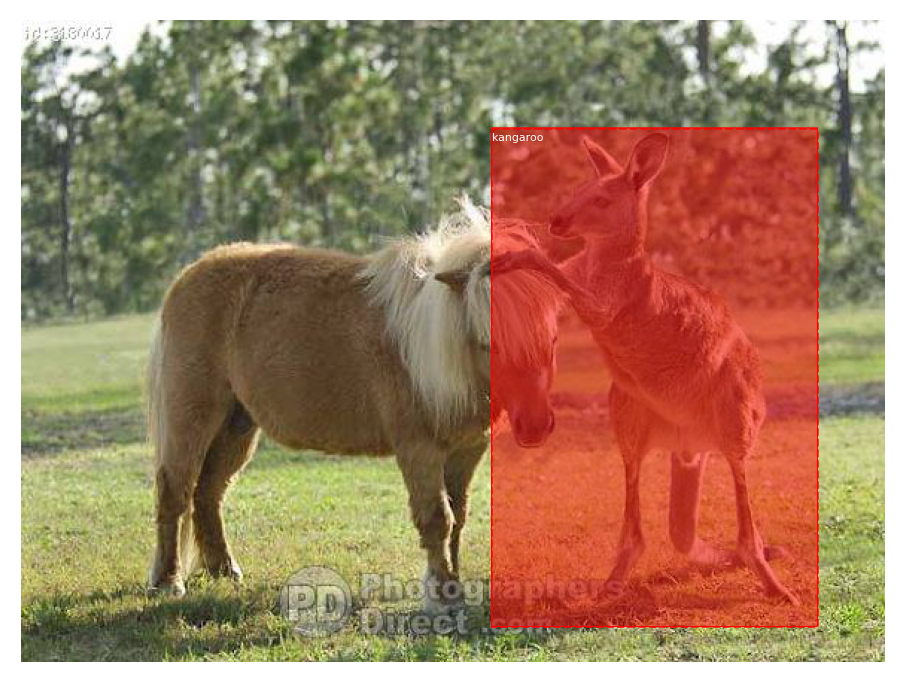

In [20]:
print('La libraría mask-rcnn proporciona utilidades para mostrar imágenes y máscaras.')

# Extrayendo Bounding-box de las máscaras
bbox = extract_bboxes(mask)
# Mostrar imagen con máscaras y Bounding-box.
display_instances(image, bbox, mask, class_ids, train_set.class_names)

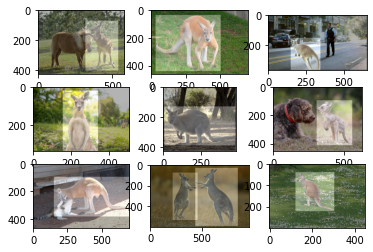

In [21]:
# Probando las primeras nueve fotos:
for i in range(9):
	# Definir subplot
	pyplot.subplot(330 + 1 + i)
	# Ploteo de de las imagenes
	image = train_set.load_image(i)
	pyplot.imshow(image)
	# Ploteo de sus máscaras
	mask, _ = train_set.load_mask(i)
	for j in range(mask.shape[2]):
		pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
  
# Ver la figura
pyplot.show()

In [22]:
# Enumerar todas las imagenes en el dataset de entrenamiento, solo para comprobar
for image_id in train_set.image_ids:
	# Cargar la información de las imagenes
	info = train_set.image_info[image_id]
	# Mostrar en consola
	print(info)

{'id': '00146', 'source': 'dataset', 'path': 'kangaroo/images/00146.jpg', 'annotation': 'kangaroo/annots/00146.xml'}
{'id': '00074', 'source': 'dataset', 'path': 'kangaroo/images/00074.jpg', 'annotation': 'kangaroo/annots/00074.xml'}
{'id': '00098', 'source': 'dataset', 'path': 'kangaroo/images/00098.jpg', 'annotation': 'kangaroo/annots/00098.xml'}
{'id': '00055', 'source': 'dataset', 'path': 'kangaroo/images/00055.jpg', 'annotation': 'kangaroo/annots/00055.xml'}
{'id': '00084', 'source': 'dataset', 'path': 'kangaroo/images/00084.jpg', 'annotation': 'kangaroo/annots/00084.xml'}
{'id': '00049', 'source': 'dataset', 'path': 'kangaroo/images/00049.jpg', 'annotation': 'kangaroo/annots/00049.xml'}
{'id': '00100', 'source': 'dataset', 'path': 'kangaroo/images/00100.jpg', 'annotation': 'kangaroo/annots/00100.xml'}
{'id': '00116', 'source': 'dataset', 'path': 'kangaroo/images/00116.jpg', 'annotation': 'kangaroo/annots/00116.xml'}
{'id': '00052', 'source': 'dataset', 'path': 'kangaroo/images/00

### Configuración del modelo

In [23]:
# Definir la configuración del modelo
class KangarooConfig(Config):
	# Definir el nombre del archivo de configuración
	NAME = "kangaroo_cfg"
	# Número de clases (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# Número de pasos de entrenamiento por epoch
	STEPS_PER_EPOCH = 131


In [24]:
# Preparar configuración
config = KangarooConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

### Aplicación del modelo

In [25]:
# Definición del modelo
# Finalmente, se necesita un directorio donde se puedan guardar los archivos de configuración y donde se puedan guardar los modelos de puntos de control al final de cada época
# Se usará el directorio de trabajo actual
model = MaskRCNN(mode='training', model_dir=rutaRaiz+'/configuracion/', config=config)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [26]:
# Carga de los pesos del dataset coco excluyendo las capas de salida
model.load_weights(rutaRaiz+'/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# Entrenando con pesos train y considerando las salidas
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')








Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/ciclo_02/deep_learning/proyecto_RedesConvolucionales/od_wilber/configuracion/kangaroo_cfg20201016T0006/mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/5
131/131 [==============================] - 211s 2s/step - loss: 0.9685 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.2264 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.3788 - mrcnn_mask_loss: 0.3110 - val_loss: 0.8112 - val_rpn_class_loss: 0.0100 - val_rpn_bbox_loss: 0.2429 - val_mrcnn_class_loss: 0.0354 - val_mrcnn_bbox_loss: 0.2585 - val_mrcnn_mask_loss: 0.2644

Epoch 2/5
131/131 [==============================] - 152s 1s/step - loss: 0.5679 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1359 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.1636 - mrcnn_mask_loss: 0.2377 - val_loss: 0.6529 - val_rpn_class_loss: 0.0073 - val_rpn_bbox_loss: 0.2263 - val_mrcnn_class_loss: 0.0286 - val_mrcnn_bbox_loss: 0.1651 - val_mrcnn_mask_loss: 0.2256
Epoch 3/5
131/131 [==============================] - 151s 1s/step - loss: 0.4768 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1235 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.1082 - mrcnn_mask_loss: 0.2180 - val_loss: 0.7760 - val_rpn_class_l